# Food Poisoning Claims Analysis 

**Table of Contents**

- [Company Background](#company-background)
- [Customer Question](#customer-question)
- [Added Questions for better insights](#added-questions-for-better-insights)
- [Dataset](#dataset)
- [Data Validation](#data-validation)
- [Data Validation Results](#data-validation-results)
- [Data Discovery and Visualisation](#data-discovery-and-visualization)
  - [Customer Questions](#customer-questions)
  - [Added Questions](#added-questions)
- [Findings](#findings)
- [Recommendations](#recommendations)

## Company Background
Vivendo is a fast food chain in Brazil with over 200 outlets. Customers often claim compensation from the company for food poisoning. The legal team processes these claims. The legal team has offices in four locations.

## Customer Question

The legal team wants to improve how long it takes to reply to customers and close claims. They want to know:

- Which location has the most claims.
- Whether the claims are balanced across locations.
- How time to close for all claims is distributed.
- How each location differs in the time it takes to close claims.

## Added Questions for better insights

- How individuals on claim influence the time to close the claim.
- How time to close for all claims differs between linked cases and not linked ones.
- Is there is relation between location and cause of poisoning
- How cause of poisoning affects time to close the claim. 

## Dataset

The dataset contains one row for each claim.

|     Column Name      | Criteria                                                                                        |
|:--------------------:|-------------------------------------------------------------------------------------------------|
|       claim_id       | Nominal. The unique identifier of the claim.                                                    |
|    time_to_close     | Discrete. The number of days to close the claim. Any positive value.                            |
|     claim_amount     | Continuous. The initial claim requested in the currency of Brazil, rounded to 2 decimal places. |
|     amount_paid      | Continuous. Final amount paid. In the currency of Brazil. Rounded to 2 decimal places.          |
|       location       | Nominal. Location of the claim, one of “RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”.           |
| individuals_on_claim | Discrete. Number of individuals on this claim. Minimum 1 person.                                |
|     linked_cases     | Nominal. Whether this claim is linked to other cases. Either TRUE or FALSE.                     |
|        cause         | Nominal. Cause of the food poisoning. One of “vegetable”, “meat” or “unknown”.                  |

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns

data = pd.read_csv("food_claims_2212.csv")


## Data Validation

In [2]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_id              2000 non-null   int64  
 1   time_to_close         2000 non-null   int64  
 2   claim_amount          2000 non-null   object 
 3   amount_paid           1964 non-null   float64
 4   location              2000 non-null   object 
 5   individuals_on_claim  2000 non-null   int64  
 6   linked_cases          1974 non-null   object 
 7   cause                 2000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


After reading the CSV file, the first thing we do is checking data type of each column with the `dtype` attribute and calculating missing values.

The original data is **2000** rows and **8** columns.

There are 

- 36 missing values in `amount_paid`,
- 26 missing values in `linked_cases`,

so we need to fill them.

It shows that `claim_amount` is an object, so we need to make data conversions to float64 to match the criteria of the data dictionary.

### claim_id

In [3]:
data["claim_id"].nunique()


2000

**Conclusion**: There are 2000 unique values, as expected.

### time_to_close

In [4]:
data["time_to_close"].min()


76

**Conclusion**: There is no negative values, as expected.

### claim_amount

In [5]:
data["claim_amount"].head()


0    R$ 74474.55
1    R$ 52137.83
2     R$ 24447.2
3    R$ 29006.28
4     R$ 19520.6
Name: claim_amount, dtype: object

We combine the `removeprefix()` and `astype()` functions to replace the unwanted "R$ " prefix and convert data from object to float64.

In [6]:
data["claim_amount"] = data["claim_amount"].str.removeprefix("R$ ").astype("float")
data["claim_amount"].dtypes


dtype('float64')

**Conclusion**: `claim_amount` values were converted to float to match the description given in the table.

### amount_paid

We replace missing values with the overall median amount paid rounded to 2 decimal places.

In [7]:
data["amount_paid"].fillna(round(data["amount_paid"].median(), 2), inplace=True)
data["amount_paid"].isna().value_counts()


False    2000
Name: amount_paid, dtype: int64

**Conclusion**: 36 missing values were replaced with the overall median amount paid rounded to 2 decimal places to match the description given in the table.

### location

In [8]:
data["location"].value_counts()


RECIFE       885
SAO LUIS     517
FORTALEZA    311
NATAL        287
Name: location, dtype: int64

**Conclusion**: There are 4 unique values (“RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”), as expected. 

### individuals_on_claim

In [9]:
data["individuals_on_claim"].min()


1

**Conclusion**: Minimum 1 person, as expected.

### linked_cases

In [10]:
data["linked_cases"].value_counts()


False    1493
True      481
Name: linked_cases, dtype: int64

There are only boolean values, as expected. 
There are 26 missing values. We replace them with `False`.

In [11]:
data["linked_cases"].fillna(False, inplace=True)
data["linked_cases"].value_counts()


False    1519
True      481
Name: linked_cases, dtype: int64

**Conclusion**: 26 missing values were replaced with `False` to match the description given in the table.

### cause

In [12]:
data["cause"].value_counts()


meat          943
unknown       713
vegetable     314
VEGETABLES     16
 Meat          14
Name: cause, dtype: int64

Only 'vegetable', 'meat' or 'unknown' values were expected. We convert values to lowercase, stripping whitespaces, and replacing 'vegetables' with 'vegetable'.

In [13]:
data["cause"] = (
    data["cause"].str.lower().str.lstrip().replace("vegetables", "vegetable")
)
data["cause"].value_counts()


meat         957
unknown      713
vegetable    330
Name: cause, dtype: int64

**Conclusion**: Replaced 30 unexpected values to match the description given in the table.

## Data Validation Results 

After validation the data is **2000** rows and **8** columns.


|     Column Name      | Validation Result                                                                                            |
|:--------------------:|--------------------------------------------------------------------------------------------------------------|
|       claim_id       | 2000 unique values, as expected.                                                                             |
|    time_to_close     | No negative values, as expected.                                                                             |
|     claim_amount     | Values were converted to `float64`.                                                                          |
|     amount_paid      | 36 missing values were replaced with the overall median amount paid rounded to 2 decimal places.             |
|       location       | 4 unique values (“RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”), as expected.                                |
| individuals_on_claim | Minimum 1 person, as expected.                                                                               |
|     linked_cases     | 26 missing values were replaced with `False`.                                                                |
|        cause         | Transformed 30 values to lowercase, stripped leading whitespaces and replaced "vegetables" with "vegetable". |

## Data Discovery and Visualization

### Customer Questions

#### Number of claims in each location

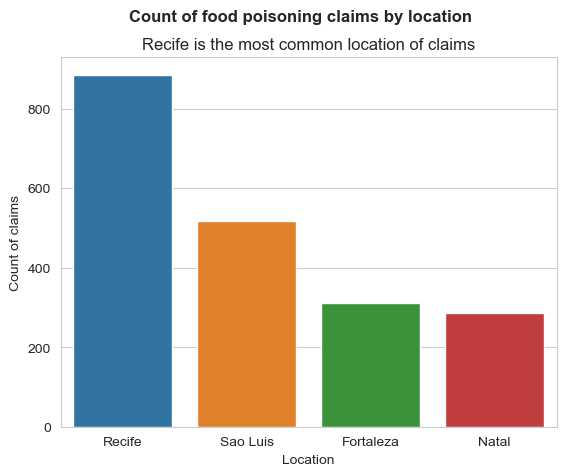

In [14]:
sns.set_style("whitegrid")

sns.countplot(
    x=data["location"].str.title(), order=["Recife", "Sao Luis", "Fortaleza", "Natal"]
)

plt.suptitle("Count of food poisoning claims by location", fontweight="bold")
plt.title("Recife is the most common location of claims")
plt.xlabel("Location")
plt.ylabel("Count of claims")

plt.show()


There are four possible locations included in this data.

The most common location is Recife, with São Luis being second although with almost half the number of claims.
The other two locations, Fortaleza and Natal, have almost the same number of claims, around half the number of claims in São Luis.

This would suggest that the legal team should focus on processing claims from Recife and São Luis as they are more common.



#### Distribution of time to close for all claims

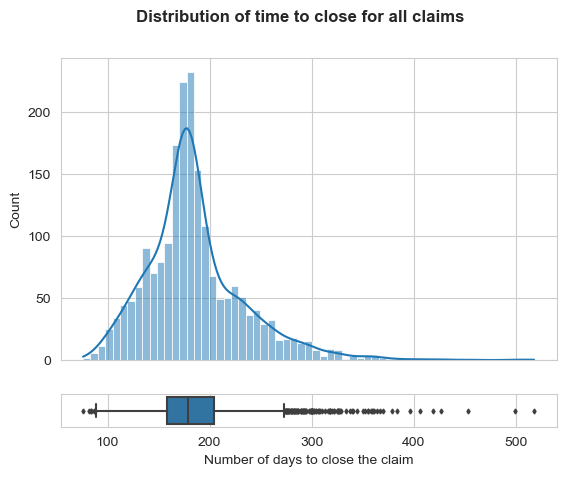

In [15]:
f, (ax_hist, ax_box) = plt.subplots(
    2, sharex='all', gridspec_kw={"height_ratios": (0.9, 0.1)}
)

sns.histplot(data=data, x="time_to_close", ax=ax_hist, kde=True)
sns.boxplot(data=data, x="time_to_close", ax=ax_box, fliersize=2.5)

f.suptitle("Distribution of time to close for all claims", fontweight="bold")
plt.xlabel("Number of days to close the claim")

plt.show()


Looking at the number of days to close the claim, we can see that most claims (75th percentile) had been closed in 200 days. The median time to close the claim is 179 days. 

Some outliers take more than 300 days but this is less common. 

#### Relationship between time to close and location

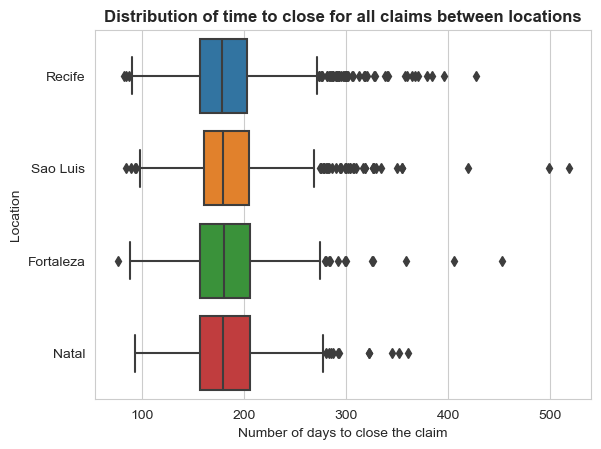

In [16]:
sns.boxplot(
    y=data["location"].str.title(),
    x=data["time_to_close"],
    order=["Recife", "Sao Luis", "Fortaleza", "Natal"],
)

plt.title(
    "Distribution of time to close for all claims between locations", fontweight="bold"
)
plt.xlabel("Number of days to close the claim")
plt.ylabel("Location")

plt.show()


Although distribution of time to close the claim looks similar between locations, the number of outliers is higher in Recife and São Luis. This would suggest that claims than take more than 300 days to close come from these locations. This could be an effect of having the larger than Fortaleza and Natal number of claims, so the large number of claims brings number of days to close the claim up.

We can conduct ANOVA to see if there is any statistically significant difference between locations.

$\alpha = 0.05\newline$
$H_0 : \mu_{Recife} = \mu_{Sao\space Luis} = \mu_{Fortaleza} = \mu_{Natal}\newline$
$H_1 : \text{Means are not all equal}\newline$

In [17]:
pg.anova(
    data=data,
    dv="time_to_close",
    between="location",
).round(3)


,Source,ddof1,ddof2,F,p-unc,np2
0,location,3,1996,0.303,0.823,0.0


We fail to reject the null hypothesis because $\text{P-value}$ is greater than $\alpha$. It means that there is no statistically significant difference between locations.

Based on all of the above, we recommend team to also consider if correlation between other variables and time to close the claim exists. Further analysis is recommended and provided below.

### Added Questions

#### Individuals on claim influence to time to close the claim.

We can add individuals on claim to previous plot using hue. 

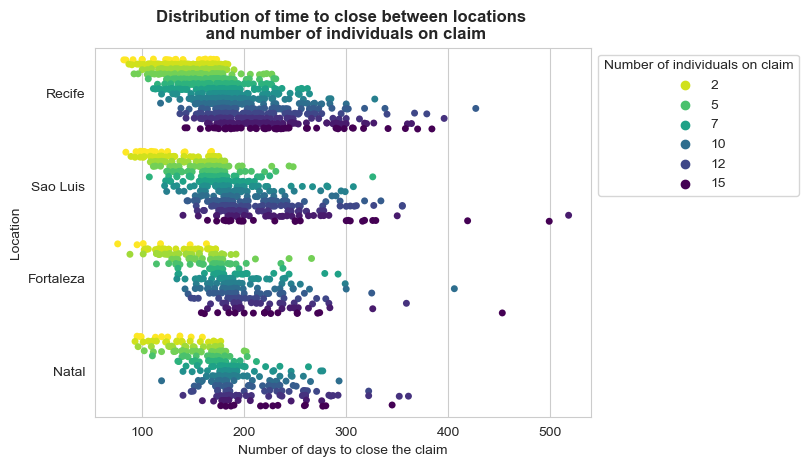

In [18]:
ax = sns.stripplot(
    data=data,
    x="time_to_close",
    y=data["location"].str.title(),
    order=["Recife", "Sao Luis", "Fortaleza", "Natal"],
    hue="individuals_on_claim",
    palette="viridis_r",
    dodge=True,
)

plt.title(
    "Distribution of time to close between locations \n and number of individuals on claim",
    fontweight="bold",
)
plt.xlabel("Number of days to close the claim")
plt.ylabel("Location")
plt.legend(title="Number of individuals on claim")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


As we can see, number of individuals on claim strongly impacts number of days to close the claim. We can explore this relation using box plot and calculating correlation coefficient.

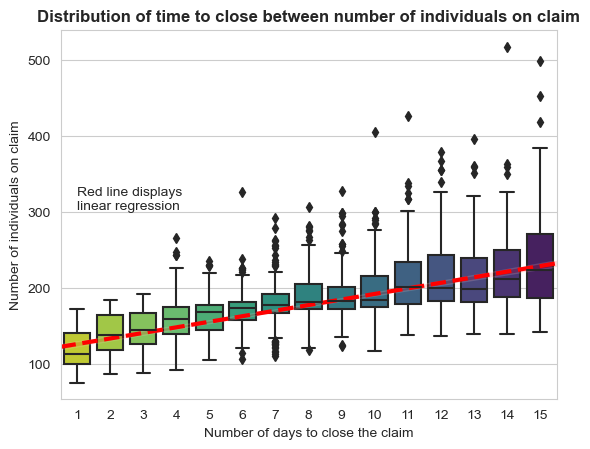

In [19]:
f, ax = plt.subplots()

sns.boxplot(
    data=data,
    x="individuals_on_claim",
    y="time_to_close",
    orient="v",
    ax=ax,
    palette="viridis_r",
)

sns.regplot(
    data=data,
    x="individuals_on_claim",
    y="time_to_close",
    scatter=False,
    truncate=False,
    ax=ax,
    color="red",
    line_kws={"linewidth": 3, "ls": "--"},
)

plt.title(
    "Distribution of time to close between number of individuals on claim",
    fontweight="bold",
)
plt.xlabel("Number of days to close the claim")
plt.ylabel("Number of individuals on claim")

plt.text(
    0,
    300,
    "Red line displays\nlinear regression",
    horizontalalignment="left",
    verticalalignment="bottom",
)

plt.show()


In [20]:
print(
    f'Correlation coefficient: {round(data["time_to_close"].corr(data["individuals_on_claim"]),2)}'
)


Correlation coefficient: 0.61


As we see on box plot, the higher number of individuals on claim associated with higher number of days to close the claim. Correlations coefficient supports this claim.

#### Linked and unlinked claims time to close.

As we know now, number of individuals on claim associated with higher time to close the claim. We decide to include this factor into next visualisation.

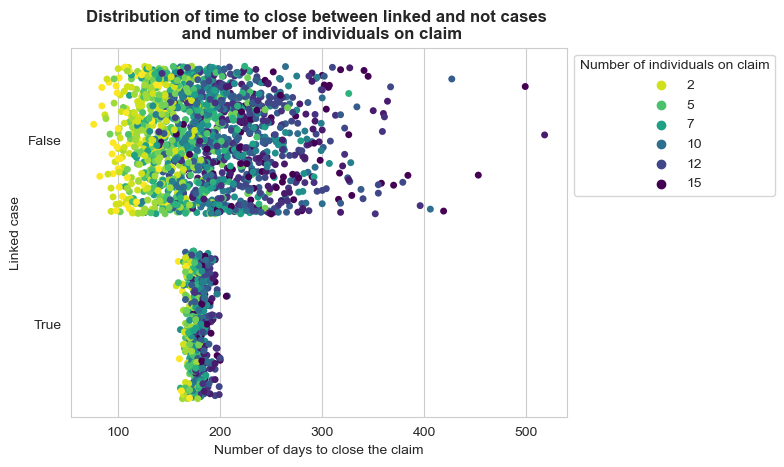

In [21]:
ax = sns.stripplot(
    data=data,
    x="time_to_close",
    y="linked_cases",
    hue="individuals_on_claim",
    palette="viridis_r",
    orient="h",
    jitter=0.4,
)

plt.title(
    "Distribution of time to close between linked and not cases \n and number of individuals on claim",
    fontweight="bold",
)
plt.xlabel("Number of days to close the claim")
plt.ylabel("Linked case")
plt.legend(title="Number of individuals on claim")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


Linked cases are commonly closed after 172 to 183 days and spread of time to close is much lower than in unlinked cases. Further analysis is recommended.

#### Relation between location and cause of poisoning.

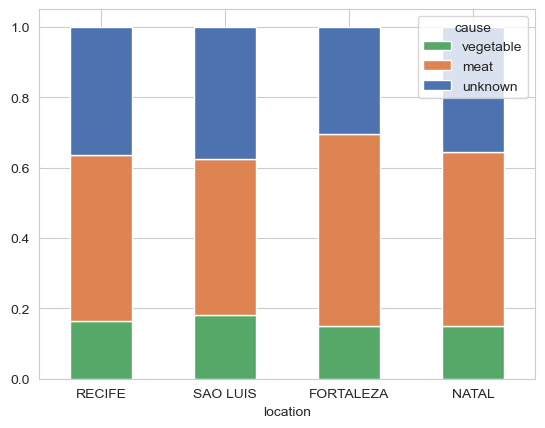

In [22]:
data.groupby("location")[["cause"]].value_counts(normalize=True).unstack().reindex(
    ["RECIFE", "SAO LUIS", "FORTALEZA", "NATAL"]
).reindex(columns=["vegetable", "meat", "unknown"]).plot(
    kind="bar",
    stacked=True,
    color=["#55a868", "#dd8452", "#4c72b0"],
)
plt.xticks(rotation=0)
plt.show()


Check if location and cause of poisoning are associated.

We can conduct $\Chi^2$-test of independence to see if there is any statistically significant relation between two categorical variables.

$\alpha = 0.05$

In [23]:
expected, observed, stats = pg.chi2_independence(data=data, x="cause", y="location")
stats[stats["test"] == "pearson"].round(3)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_sf
  np.place(out, cond, f(*temp))


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,8.928,6.0,0.178,0.047,0.3


$\text{P-value}$ is greater than $\alpha$, we fail to reject the null hypothesis. Location and cause are independent.

#### Time to close claims with different causes of poisoning.

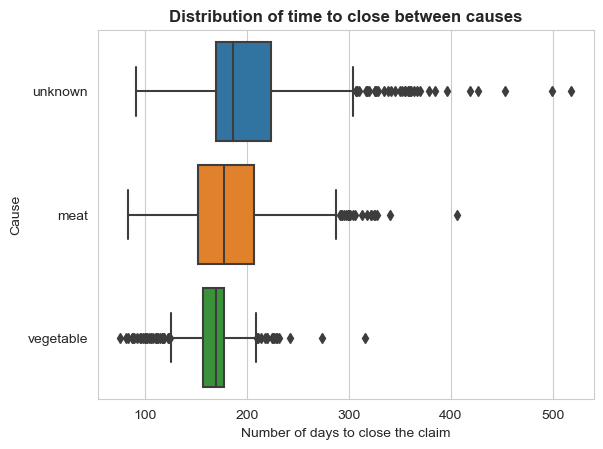

In [24]:
sns.boxplot(
    data=data,
    x="time_to_close",
    y="cause",
    orient="h",
)

plt.title(
    "Distribution of time to close between causes",
    fontweight="bold",
)
plt.xlabel("Number of days to close the claim")
plt.ylabel("Cause")

plt.show()


As we can see vegetable cause associated with faster close time. Unknown case has right-skewness and most of the outliers. It suggests that claim with unknown cause of poisoning is likely to take more time to close.

We can conduct ANOVA to see if there is any statistically significant difference between causes of poisoning.

$\alpha = 0.05\newline$
$H_0 : \mu_{unknown} = \mu_{meat} = \mu_{vegetable}\newline$
$H_1 : \text{Means are not all equal}\newline$

In [25]:
pg.anova(data=data, dv="time_to_close", between="cause").round(5)


,Source,ddof1,ddof2,F,p-unc,np2
0,cause,2,1997,62.94745,0.0,0.0593


$\alpha$ is greater than $\text{P-value}$, we reject the null hypothesis. There is significant difference in time to close the claim between causes.

## Findings

- Recife has the most claims, with São Luis being second although with almost half the number of claims. The other two locations, Fortaleza and Natal, have almost the same number of claims, around half the number of claims in São Luis.
- Time to close the claim has no statistically significant difference between locations
- Number of individuals on claim has moderate positive correlation (correlation coefficient 0.61) on number of days to close the claim.
- Linked claims have less spread in number of days to close the claim.
- Cause of poisoning and location are independent.
- Causes of poisoning influence the time to close the claim. Vegetable cause in likely to be closed in 180 days, unknown cause claims likely to have greater time to close.

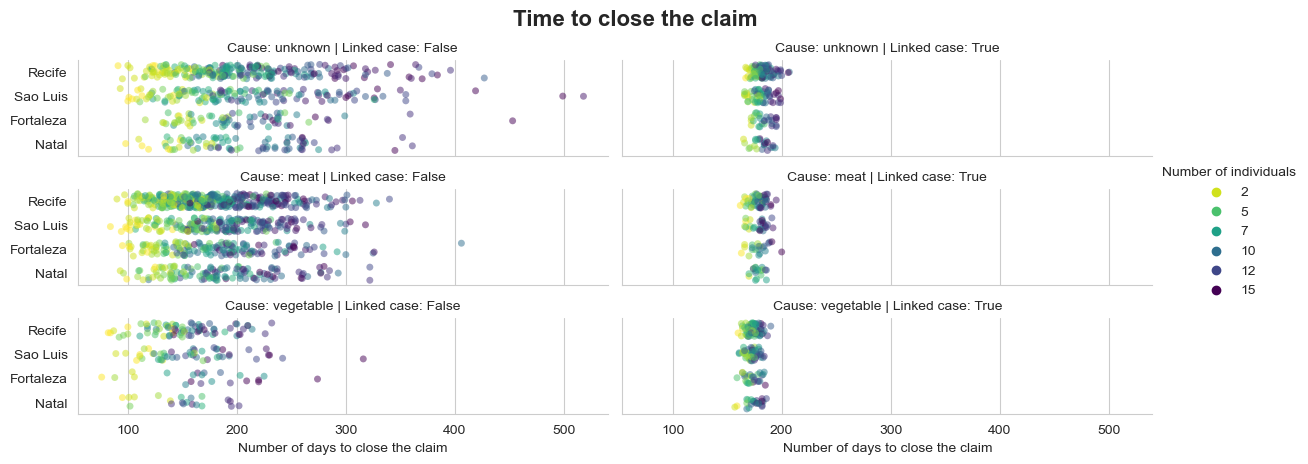

In [26]:
g = sns.catplot(
    data=data,
    x="time_to_close",
    y=data["location"].str.title(),
    order=["Recife", "Sao Luis", "Fortaleza", "Natal"],
    row="cause",
    row_order=["unknown", "meat", "vegetable"],
    col="linked_cases",
    hue="individuals_on_claim",
    palette="viridis_r",
    jitter=0.3,
    alpha=0.5,
    height=1.5,
    aspect=4,
)

g.figure.suptitle(
    "Time to close the claim\n ",
    size=16,
    y=1.04,
    fontweight="bold",
)
g.set_titles(col_template="Linked case: {col_name}", row_template="Cause: {row_name}")

g.set_axis_labels("Number of days to close the claim", "")
g.legend.set(title="Number of individuals")

plt.show()


## Recommendations

- Since claims with high number of individuals take longer to close, focusing the legal team work on those claims can help decrease mean time to process claims.
- Claims with 'unknown' or 'meat' reasons of poisoning take longer to process. Prioritizing such claims can help decrease mean time to process claims.
- Linked cases should be studied further to understand differences with unlinked cases.
- This study did not cover claim amount and amount paid variables. They should be studied if necessary.